In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading and Converting to Dataframe

In [3]:
def load_dataset(download_dir, download_needed, batch_size, t):
    train_set = torchvision.datasets.EMNIST(
        root=download_dir,
        split="letters",
        train=True,
        download=download_needed,
        transform=transforms.Compose(t)
    )

    train_loader = DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True,
        pin_memory=True
    )

    test_set = torchvision.datasets.EMNIST(
        root=download_dir,
        split="letters",
        train=False,
        download=download_needed,
        transform=transforms.Compose(t)
    )

    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )

    return train_loader, train_set, test_loader, test_set

download_dir = "./downloads"
batch_size = 1024

train_loader, train_set, test_loader, test_set = load_dataset(download_dir, True, batch_size, [transforms.ToTensor()])

In [ ]:
def generate_dataset(dataset):

    data = []
    labels = []

    for index, (image, label) in enumerate(dataset):   
        flattened_img = np.array(image).flatten()
        data.append(flattened_img)
        labels.append(label)

        if index % 10000 == 0:
            print(f"Curr Index:", index)

    return data, labels

Curr Index: 0
Curr Index: 10000
Curr Index: 20000
Curr Index: 30000
Curr Index: 40000
Curr Index: 50000
Curr Index: 60000
Curr Index: 70000
Curr Index: 80000
Curr Index: 90000
Curr Index: 100000
Curr Index: 110000
Curr Index: 120000


In [9]:
data, labels = generate_dataset(train_set)
train_df = pd.DataFrame(data, columns=[f"pixel_{i}" for i in range(28 * 28)])
train_df['label'] = labels
train_df.to_csv("emnist-train.csv")

Curr Index: 0
Curr Index: 10000
Curr Index: 20000
Curr Index: 30000
Curr Index: 40000
Curr Index: 50000
Curr Index: 60000
Curr Index: 70000
Curr Index: 80000
Curr Index: 90000
Curr Index: 100000
Curr Index: 110000
Curr Index: 120000


In [10]:
train_df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23


In [11]:
data, labels = generate_dataset(test_set)
test_df = pd.DataFrame(data, columns=[f"pixel_{i}" for i in range(28 * 28)])
test_df['label'] = labels
test_df.to_csv("emnist-test.csv")

Curr Index: 0
Curr Index: 10000
Curr Index: 20000


In [12]:
test_df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Data Splitting

In [15]:
X_train = train_df.iloc[:, :-1]
X_test = test_df.iloc[:, :-1]
Y_train = train_df.iloc[:, -1]
Y_test = test_df.iloc[:, -1]

### Logistic Regression

In [20]:
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train, Y_train)

/home/pmoha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [21]:
log_reg_preds = log_reg.predict(X_test)
log_reg_acc = accuracy_score(Y_test, log_reg_preds)
log_reg_acc

0.718125

### Random Forest

In [22]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [23]:
rf_preds = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test, rf_preds)
rf_acc

0.8864423076923077

### Quadratic Discriminant Analysis (QDA)

In [24]:
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, Y_train)

/home/pmoha/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [25]:
qda_preds = qda_clf.predict(X_test)
qda_acc = accuracy_score(Y_test, qda_preds)
qda_acc

0.04091346153846154

### Principal Component Analysis (PCA)

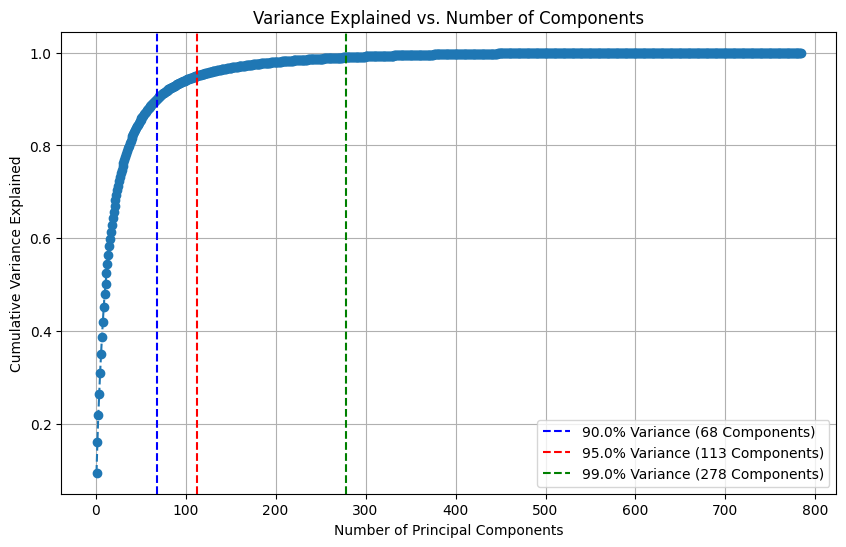

In [31]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Variance Explained vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()

threshold = 0.90
n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
plt.axvline(x=n_components_needed, color='b', linestyle='--', label=f'{threshold*100}% Variance ({n_components_needed} Components)')
threshold = 0.95
n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
plt.axvline(x=n_components_needed, color='r', linestyle='--', label=f'{threshold*100}% Variance ({n_components_needed} Components)')
threshold = 0.99
n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
plt.axvline(x=n_components_needed, color='g', linestyle='--', label=f'{threshold*100}% Variance ({n_components_needed} Components)')
plt.legend(loc='lower right')

plt.show()

In [32]:
n_components = 113 # 95% variance accounted for
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Logistic Regression + PCA

In [33]:
log_reg_pca = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg_pca.fit(X_train_pca, Y_train)

/home/pmoha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [39]:
log_reg_pca_preds = log_reg_pca.predict(X_test_pca)
log_reg_pca_acc = accuracy_score(Y_test, log_reg_pca_preds)
log_reg_pca_acc

0.7229326923076923

### Random Forest + PCA

In [35]:
rf_pca_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca_clf.fit(X_train_pca, Y_train)

RandomForestClassifier(random_state=42)

In [40]:
rf_pca_preds = rf_pca_clf.predict(X_test_pca)
rf_pca_acc = accuracy_score(Y_test, rf_pca_preds)
rf_pca_acc

0.8457692307692307

### QDA + PCA

In [37]:
qda_pca_clf = QuadraticDiscriminantAnalysis()
qda_pca_clf.fit(X_train_pca, Y_train)

QuadraticDiscriminantAnalysis()

In [41]:
qda_pca_preds = qda_pca_clf.predict(X_test_pca)
qda_pca_acc = accuracy_score(Y_test, qda_pca_preds)
qda_pca_acc

0.8274519230769231